In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import pyopia.exampledata as exampledata

import os
import matplotlib.pyplot as plt

In [2]:
model_path = exampledata.get_example_model()

In [3]:
# Prepare folders
os.makedirs('proc', exist_ok=True)

# remove pre-existing output file (as statistics for each image are appended to it)
datafile_nc = os.path.join('proc', 'test')
if os.path.isfile(datafile_nc + '-STATS.nc'):
  os.remove(datafile_nc + '-STATS.nc')

## Load a TOML config file containing all setttings, and pipeline steps

This creates a dict of all settings, which can be modified or writte in the same way as any other dictionary in python. This has a slightly different structure that the old 'steps' dict, but follows the same principle (look in the example config.toml file used below for more details).

In [4]:
toml_settings = pyopia.io.load_toml('config.toml')
toml_settings

{'general': {'raw_files': 'raw_data/*.silc', 'pixel_size': 24},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imraw'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85,
   'segment_source': 'im_corrected'},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats',
   'export_outputpath': 'silcam_rois',
   'roi_source': 'imref'},
  'output': {'pipeline_class': 'pyopia.io.StatsToDisc',
   'output_datafile': 'proc/test'}}}

## Run the pipeline

(same as before, but now giving Pipeline() the toml_setting dict)

In [5]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_settings)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'raw_files'])
Example image already exists. Skipping download.
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename'])
ImagePrep  ready with: {'image_level': 'imraw'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw'])
Segment  ready with: {'threshold': 0.85, 'segment_source': 'im_corrected'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'im_corrected', 'imref'])
segment
clean
CalculateStats  ready with: {'export_outputpath': 'silcam_rois', 'roi_source': 'imref'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'im_corrected', 'imref', 'imbw'])
statextract
21.7% saturation
measure
  870 particles found
EXTRACTING 870 IMAGES from 870
StatsToDisc  ready with: {'output_datafile': 'proc/test'}  and data dict_keys(['cl', 'settings'

## Load the data again

Then later, we can load the data again from NetCDF using xarray

xarray DataSets are presented nicely in notebooks (rendered poorly on GitHub's webinterface)

In [6]:
xstats = pyopia.io.load_stats('proc/test-STATS.nc')

## Alter settings and re-process

What if we wanted to re-process this dataset with a different segmentation threshold?

### Get the TOML steps from the xarray DataSet

In [7]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'raw_data/*.silc', 'pixel_size': 24},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imraw'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85,
   'segment_source': 'im_corrected'},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats',
   'export_outputpath': 'silcam_rois',
   'roi_source': 'imref'},
  'output': {'pipeline_class': 'pyopia.io.StatsToDisc',
   'output_datafile': 'proc/test'}}}

### Alter the setting we want to change

In [8]:
toml_steps['steps']['segmentation']['threshold'] = 0.9

### re-process the pipeline

In [9]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_steps)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
processing_pipeline.run(filename)
stats = processing_pipeline.data['stats']

Initialising pipeline
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'raw_files'])
Example image already exists. Skipping download.
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename'])
ImagePrep  ready with: {'image_level': 'imraw'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw'])
Segment  ready with: {'threshold': 0.9, 'segment_source': 'im_corrected'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'im_corrected', 'imref'])
segment
clean
CalculateStats  ready with: {'export_outputpath': 'silcam_rois', 'roi_source': 'imref'}  and data dict_keys(['cl', 'settings', 'raw_files', 'filename', 'timestamp', 'imraw', 'im_corrected', 'imref', 'imbw'])
statextract
24.7% saturation
measure
  1223 particles found
EXTRACTING 1222 IMAGES from 1223
StatsToDisc  ready with: {'output_datafile': 'proc/test'}  and data dict_keys(['cl', 'setting

### Further analysis

At this point we could write this to disc again (using the pyopia.io.write_stats function)

and/or we could build a new, correctly formatted, xarray for immediate use (which we will do here):

In [10]:
xstats_modified = pyopia.io.make_xstats(stats, toml_steps)
xstats_modified

<xarray.Dataset>
Dimensions:                     (index: 1223)
Coordinates:
  * index                       (index) int64 0 1 2 3 4 ... 1219 1220 1221 1222
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    major_axis_length           (index) float64 38.64 7.369 5.033 ... 7.228 6.57
    minor_axis_length           (index) float64 35.92 4.891 ... 5.181 3.574
    equivalent_diameter         (index) float64 37.12 5.863 ... 5.971 4.514
    minr                        (index) float64 3.0 3.0 ... 2.039e+03 2.042e+03
    minc                        (index) float64 281.0 1.002e+03 ... 2.367e+03
    maxr                        (index) float64 42.0 11.0 ... 2.046e+03
    ...                          ...
    probability_copepod         (index) float64 7.109e-09 5.136e-09 ... 0.07924
    probability_diatom_chain    (index) float64 1.183e-07 4.322e-08 ... 0.003025
    probability_oily_gas        (index) float64 1.0 2.446e-06 ... 0.0006031
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 24.65 24.65 ... 24.65 24.65
Attributes:
    steps:           [general]\nraw_files = "raw_data/*.silc"\npixel_size = 2...
    Modified:        2024-08-12 14:14:59.976978
    PyOpia version:  1.1.7

### Plotting

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

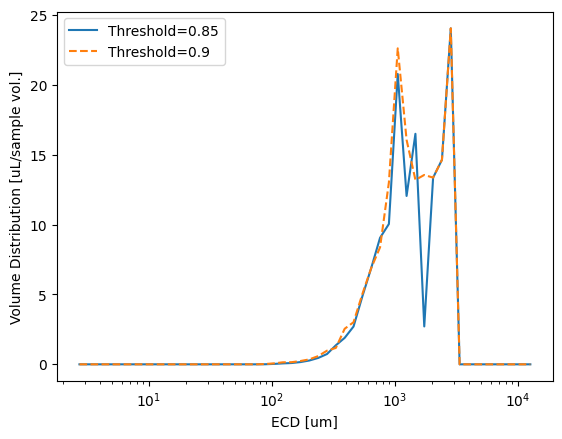

In [11]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

plt.plot(dias, vd, label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats)['steps']['segmentation']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

dias_modified, vd_modified = pyopia.statistics.vd_from_stats(xstats_modified, pyopia.pipeline.steps_from_xstats(xstats_modified)['general']['pixel_size'])

plt.plot(dias_modified, vd_modified, '--', label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']['segmentation']['threshold']}")

plt.legend()
plt.show()

rofiles: 1222
reducing particles by factor of 1
rofiles: 1222
making a montage - this might take some time....


100%|██████████| 1222/1222 [00:00<00:00, 4043.44it/s]


montage complete


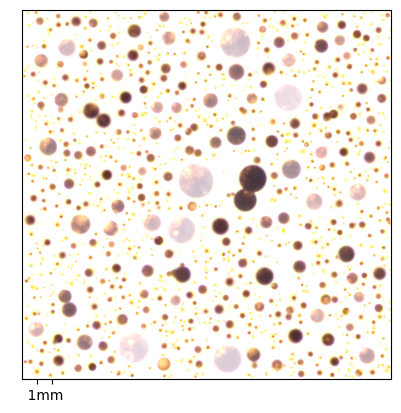

In [12]:
# create montage of focussed particles
im_mont = pyopia.statistics.make_montage(stats,
                                         pyopia.pipeline.steps_from_xstats(xstats_modified)['general']["pixel_size"],
                                         pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']["statextract"]['export_outputpath'],
                                         auto_scaler=1000, msize=1024, maxlength=100000, crop_stats=None, eyecandy=True)
pyopia.plotting.montage_plot(im_mont, pyopia.pipeline.steps_from_xstats(xstats)['general']["pixel_size"])

rofiles: 1222
reducing particles by factor of 1
rofiles: 1222
making a montage - this might take some time....


100%|██████████| 1222/1222 [00:00<00:00, 6734.23it/s]

montage complete


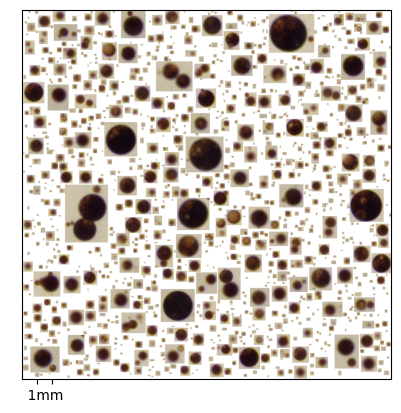

In [13]:
# create montage of focussed particles
im_mont = pyopia.statistics.make_montage(stats,
                                         pyopia.pipeline.steps_from_xstats(xstats_modified)['general']["pixel_size"],
                                         pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']["statextract"]['export_outputpath'],
                                         auto_scaler=1000, msize=1024, maxlength=100000, crop_stats=None, eyecandy=False)
pyopia.plotting.montage_plot(im_mont, pyopia.pipeline.steps_from_xstats(xstats)['general']["pixel_size"])